1. Pick size of block and size of overlap
2. synthesize blocks in raster order
3. search input texture for block that satisfies overlap constraints(above and left)
   - eash to optimize using nn search
4. paste new block into resulting texture
   - use dynamic programming to compute minimal error boundary cut

In [84]:
%matplotlib inline

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import numpy.matlib
import cv2
from skimage import io
import sys
from scipy import ndimage, signal
from random import randint, gauss
import math
from skimage.color import rgba2rgb

import timeit ## <-- New line!
import time

np.set_printoptions(threshold=sys.maxsize)

(124, 185, 3)


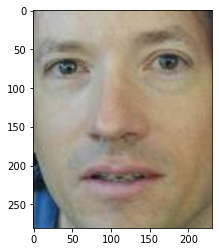

In [51]:
apples = image.imread('apples.png')
b = image.imread('bill.png')

a = rgba2rgb(apples)
print(a.shape)
plt.imshow(b)

In [52]:
if (b.shape[2] != 3):
    b = numpy.repeat(b[:, :, np.newaxis], 3, axis=2)
b.shape

(281, 231, 3)

In [53]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

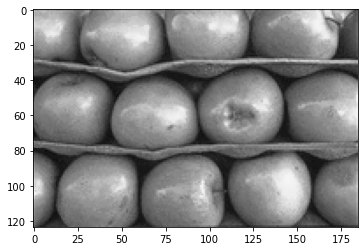

In [54]:
inputTexture = rgb2gray(a)   
inputTarget = rgb2gray(b)   

[m, n] = inputTarget.shape
plt.imshow(inputTexture, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

mask_in = inputTexture<-1;
mask_out = inputTarget<-1;

inputTexture[mask_in] = -1;
inputTarget[mask_out] = -1;


In [55]:
w = 8
al = 0.43;
o = round(w/3);
m1 = math.floor((m-o)/w)*w+o;
n1 = math.floor((n-o)/w)*w+o;

outputTexture = np.zeros([m,n])
outputTexture1 = np.zeros([m,n,3])
itera = 2

In [65]:
def findBoundaryHelper1(error):
    x, y = error.shape[0], error.shape[1] 
    path = np.zeros([x, y])
    cost = np.zeros([x, y])
    cost[x-1,:] = error[x-1,:]
    for i in range(x-2, 0, -1):
        mintree = np.array([np.append(float('+inf'), cost[i,0:y-1]), cost[i,:], np.append(cost[i,1:y], float('+inf'))], dtype=object)+ error[i-1,:] 
        cost[i,:] = np.min(mintree, axis = 0)
        path[i,:] = np.argmin(mintree, axis=0)
    np.where(path==1, path, 0)
    np.where(path==0, path, -1)
    np.where(path==2, path, 1)
    return cost, path

In [66]:
def findBoundaryHelper2(path, ind):
    m = path.shape[1]
    boundary = np.zeros([path.shape[0], path.shape[1]])
    boundary[0,0:ind] = 1
    prev = ind - 1
    for i in range(1, m-1):
        prev = prev + path[i, int(prev)]
        boundary[i, 0:int(prev)] = 1
    return boundary

In [82]:
def givePatch(al, a, inputTexture, inputTarget, temp1,mask):
    temp2 = np.linalg.multi_dot([temp1,temp1,mask])
    temp3 = np.multiply(inputTexture, inputTexture)
    temp3 = signal.convolve2d(temp3, np.rot90(mask, 2), mode='valid')
    temp4 = signal.convolve2d(inputTexture, np.rot90(np.multiply(temp1, mask), 2), mode='valid')

    temp5 = np.multiply(inputTarget, inputTarget)
    m1 = np.ones([mask.shape[0], mask.shape[1]])
    
    temp6 = signal.convolve2d(np.multiply(inputTexture, inputTexture), np.rot90(m1, 2), mode='valid')
    temp7 = signal.convolve2d(inputTexture, np.rot90(inputTarget, 2), mode='valid')

    errors = al*(np.sum(temp2)+temp3-2*temp4) + (1-al)* (np.sum(temp5)+temp6-2*temp7)
    minerror = abs(np.min(errors))
    [x,y] = np.where(errors <= minerror*1.3)
    rand_int = randint(0, len(x))
    [m,n] = mask.shape;
    nearPatch = inputTexture[x[rand_int]:x[rand_int]+m,y[rand_int]:y[rand_int]+n]
    nearPatch1 = a[x[rand_int]:x[rand_int]+m,y[rand_int]:y[rand_int]+n,:]
    return nearPatch, nearPatch1

In [83]:
for p in range(0, itera):
    for i in range(0, math.floor(m1/w)):
        for j in range(0, math.floor(n1/w)):
            if(np.all(np.all(mask_out[i*w:(i+1)*w+o,j*w:(j+1)*w+o]))):
                outputTexture[0:w+o,0:w+o] = 0
                outputTexture1[0:w+o,0:w+o] = 0
                continue
            mask = np.zeros([w+o,w+o]);
            temp1 = outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] 
            if(i==0 and j == 0):
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                outputTexture[0:w+o,0:w+o] = nearPatch
                outputTexture1[0:w+o,0:w+o,:] = nearPatch1
                continue
            elif(i==0):
                mask[:,0:o] = 1
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                error = error[:,0:o]

                [cost,path] = findBoundaryHelper1(error)
                boundary = np.zeros([w+o, w+o])
                ind = int(np.argmin(cost[0,:]))
                boundary[:,0:o] = findBoundaryHelper2(path, ind)

            elif(j==0):
                mask[0:o,:] = 1
                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)
                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                error = error[0:o,:]
                [cost,path] = findBoundaryHelper1(error.T)
                boundary = np.zeros([w+o,w+o])
                ind = int(np.argmin(cost[0,:]))
                boundary[0:o,:] = (findBoundaryHelper2(path,ind)).T
            else:
                mask[:,0:o] = 1;
                mask[0:o,:] = 1;

                [nearPatch,nearPatch1] = givePatch(al,a,inputTexture[0:w+o, 0:w+o],inputTarget[0:w+o, 0:w+o],temp1,mask)

                error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
                error1 = error[0:o,:]

                [cost1,path1] = findBoundaryHelper1(error1.T)

                error2 = error[:,0:o]

                [cost2,path2] = findBoundaryHelper1(error2)

                cost = np.add(cost1[0:o,:], cost2[0:o,:])
                boundary =  np.zeros([w+o,w+o])

                ind = int(np.argmin(np.diag(cost)))
                boundary[0:o,ind:w+o] = (findBoundaryHelper2(path1[ind:o+w,:],o-ind)).T

                boundary[ind:o+w,0:o] = findBoundaryHelper2(path2[ind:o+w,:], ind)

                boundary[0:ind,0:ind] = 1
                
            smoothBoundary = boundary.T
            smoothBoundary1 = numpy.repeat(boundary[:, :, np.newaxis], 3, axis=2)
            temp2 = np.multiply(temp1, smoothBoundary) + np.multiply(nearPatch, (1-smoothBoundary))
            outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] = temp2
            outputTexture1[i*w:(i+1)*w+o,j*w:(j+1)*w+o,:] = np.multiply(outputTexture1[i*w:(i+1)*w+o, j*w:(j+1)*w+o,:], smoothBoundary1) + np.multiply(nearPatch1, (1-smoothBoundary1))
    output = outputTexture1[0:m,0:n,:]
    output[numpy.repeat(mask_out[:, :, np.newaxis], 3, axis=2)] = 0
 
    w = round(w*0.7);
    o = round(w/3);
    if(itera > 1):
        al = 0.8*(p-1)/(iter-1)+0.1;
    else:
        continue;
    
    inputTarget = outputTexture;
    inputTexture[mask_in]=-1;
    inputTarget[mask_out]=-1;
    
    [m,n] = inputTarget.shape[0], inputTarget.shape[1]
    m1 = math.floor((m-o)/w)*w+o;
    n1 = math.floor((n-o)/w)*w+o;
    
    outputTexture = np.zeros([m,n]);
    outputTexture1 = np.zeros([m,n,3]);
    plt.imshow(output)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [79]:
math.floor(n1/w)

28